# 100% RE by 2050 and the Effects of Lifetime and Recycling

Comparison case using the functions in PV ICE to compare how PV module lifetime and PV module recycling effect the energy transition to 100% clean energy by 2050.





![Folder 15 vs 50 year Module](../images_wiki/2_15vs50Overview.PNG)

In [1]:
import PV_ICE
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
from IPython.display import display
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (12, 8)

import os
from pathlib import Path

PV_ICE.__version__

'v0.2.0+169.gf24c0ba.dirty'

In [2]:
testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'SFs_LifeVSRecycle')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
materialsfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
print ("Your simulation will be stored in %s" % testfolder)
print("Your simulation input data will be written/read from %s" % inputfolder)
print("Material files will be from %s" % materialsfolder)

Your simulation will be stored in C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\SFs_LifeVSRecycle
Your simulation input data will be written/read from C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP
Material files will be from C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\baselines


In [3]:
if not os.path.exists(testfolder):
    os.makedirs(testfolder)

# Deployment Schedule File Preparation

NOTE: this section of code should only need to be run once to populate data, and again anytime the ReeDS file is updated.

First, we load the Module Baseline. This file will be used later to populate all the columns other than 'new_Installed_Capacity_[MW]'. Deployment schedule for this analysis will be supplied by the REEDS model. This analysis will use PV ICE developed material and module baselines.

In [4]:
rtest = PV_ICE.Simulation(name='Sim1', path=inputfolder)
rtest.createScenario(name='test', file=r'..\baselines\baseline_modules_US.csv')
baseline = rtest.scenario['test'].data
baseline = baseline.drop(columns=['new_Installed_Capacity_[MW]'])
baseline.set_index('year', inplace=True)
baseline.index = pd.PeriodIndex(baseline.index, freq='A')  # A -- Annual
#baseline.head(5)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP


Drop 1995 through 2009 because chosen deployment schedule begins in 2010. Technically this neglects ~1.5 GW of installs from 1995 through 2009.

In [5]:
baseline.drop(baseline.loc['1995':'2009'].index, inplace=True)

Now we load the deployment schedule. This is derived from ReEDS simulation output, and in this case we're using one of the deployment projections as used in Solar Futures (includes PCA regions, States). 

NOTE: The ReEDS deployment file is stored outside of the PV ICE folder and therefore not publicly available on github. Please contact the authors for this file.

In [6]:
#please contact the authors for this file
reedsFile = str(Path().resolve().parent.parent.parent / 'December Core Scenarios ReEDS Outputs Solar Futures v3a.xlsx')
print ("Input file is stored in %s" % reedsFile)

Input file is stored in C:\Users\hmirletz\Documents\GitHub\December Core Scenarios ReEDS Outputs Solar Futures v3a.xlsx


In [7]:
REEDSInput = pd.read_excel(reedsFile, sheet_name="new installs PV")
#NEED TO CHECK THAT AC to DC has been taken care of in excel file (there is a multiplier, is set to 1)

First create a copy which groups the data by PCA region

In [8]:
rawdf = REEDSInput.copy()
rawdf.drop(columns=['State'], inplace=True)
rawdf.drop(columns=['Tech'], inplace=True) #tech=pvtotal from "new installs PV sheet", so can drop
rawdf.set_index(['Scenario','Year','PCA'], inplace=True)

For each Scenario and for each PCA, combine with baseline and save as input file. This will be in a folder PCAs under the simulation folder in TEMP

In [9]:
for ii in range (len(rawdf.unstack(level=1))):
    PCA = rawdf.unstack(level=1).iloc[ii].name[1]
    SCEN = rawdf.unstack(level=1).iloc[ii].name[0]
    SCEN=SCEN.replace('+', '_')
    filetitle = SCEN+'_'+PCA +'.csv'
    subtestfolder = os.path.join(testfolder, 'PCAs')
    if not os.path.exists(subtestfolder):
        os.makedirs(subtestfolder)
    filetitle = os.path.join(subtestfolder, filetitle)
    A = rawdf.unstack(level=1).iloc[ii]
    A = A.droplevel(level=0)
    A.name = 'new_Installed_Capacity_[MW]'
    A = pd.DataFrame(A)
    A.index=pd.PeriodIndex(A.index, freq='A')
    A = pd.DataFrame(A)
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 0.85
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.
    # Add other columns
    A = pd.concat([A, baseline.reindex(A.index)], axis=1)
   
    header = "year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,"\
    "mod_lifetime,mod_MFG_eff,mod_Repair,mod_MerchantTail,mod_EOL_collection_eff,mod_EOL_pg0_resell,"\
    "mod_EOL_pg1_landfill,mod_EOL_pg2_stored,mod_EOL_pg3_reMFG,mod_EOL_pg4_recycled,mod_EOL_reMFG_yield,"\
    "mod_EOL_sp_reMFG_recycle,mod_EOL_pb1_landfill,mod_EOL_pb2_stored,mod_EOL_pb3_reMFG,mod_EOL_pb4_recycled\n"\
    "year,MW,%,years,years,%,years,%,%,%,%,%,%,%,%,%,%,%,%,%,%,%\n"

    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        A.to_csv(ict, header=False)

For each Scenario and each State, combine with baseline file and save as input file. This will be in a folder States under the simulation folder in TEMP

In [10]:
rawdf = REEDSInput.copy()
#rawdf.drop(columns=['State'], inplace=True)
rawdf.drop(columns=['Tech'], inplace=True)
rawdf.set_index(['Scenario','Year','PCA', 'State'], inplace=True)

In [11]:
df = rawdf.groupby(['Scenario','State', 'Year'])['Capacity (GW)'].sum()
df = pd.DataFrame(df)

In [12]:
for ii in range (len(df.unstack(level=2))):   
    STATE = df.unstack(level=2).iloc[ii].name[1]
    SCEN = df.unstack(level=2).iloc[ii].name[0]
    SCEN=SCEN.replace('+', '_')
    filetitle = SCEN+'_'+STATE +'.csv'
    
    subtestfolder = os.path.join(testfolder, 'States')
    if not os.path.exists(subtestfolder):
        os.makedirs(subtestfolder)
    filetitle = os.path.join(subtestfolder, filetitle)

    A = df.unstack(level=2).iloc[ii]
    A = A.droplevel(level=0)
    A.name = 'new_Installed_Capacity_[MW]'
    A = pd.DataFrame(A)
    A.index=pd.PeriodIndex(A.index, freq='A')
    A = pd.DataFrame(A)
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 0.85 # marketshares['Si']
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.
    # Add other columns
    A = pd.concat([A, baseline.reindex(A.index)], axis=1)
    
    
    header = "year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,"\
    "mod_lifetime,mod_MFG_eff,mod_Repair,mod_MerchantTail,mod_EOL_collection_eff,mod_EOL_pg0_resell,"\
    "mod_EOL_pg1_landfill,mod_EOL_pg2_stored,mod_EOL_pg3_reMFG,mod_EOL_pg4_recycled,mod_EOL_reMFG_yield,"\
    "mod_EOL_sp_reMFG_recycle,mod_EOL_pb1_landfill,mod_EOL_pb2_stored,mod_EOL_pb3_reMFG,mod_EOL_pb4_recycled\n"\
    "year,MW,%,years,years,%,years,%,%,%,%,%,%,%,%,%,%,%,%,%,%,%\n"

    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        A.to_csv(ict, header=False)

Finally, make an overall US baseline which ignores PCA regions and states. This is useful for speeding the simulation and is the deployment schedule used in this analysis.

In [13]:
rawdf = REEDSInput.copy()
#rawdf.drop(columns=['State'], inplace=True)
rawdf.drop(columns=['Tech'], inplace=True)
rawdf.set_index(['Scenario','Year'], inplace=True)

In [14]:
df = rawdf.groupby(['Scenario','Year'])['Capacity (GW)'].sum()

In [15]:
for ii in range (len(df.unstack(level=1))):
    SCEN = df.unstack(level=1).index[ii]
    SCEN=SCEN.replace('+', '_')
    filetitle = SCEN+'.csv'
    
    subtestfolder = os.path.join(testfolder, 'USA')
    if not os.path.exists(subtestfolder):
        os.makedirs(subtestfolder)
    filetitle = os.path.join(subtestfolder, filetitle)
    
    A = df.unstack(level=1).iloc[ii]

    A.name = 'new_Installed_Capacity_[MW]'
    A = pd.DataFrame(A)
    A.index=pd.PeriodIndex(A.index, freq='A')
    A = pd.DataFrame(A)
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 0.85 # marketshares['Si']
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.
    # Add other columns
    A = pd.concat([A, baseline.reindex(A.index)], axis=1)
   
    header = "year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,"\
    "mod_lifetime,mod_MFG_eff,mod_Repair,mod_MerchantTail,mod_EOL_collection_eff,mod_EOL_pg0_resell,"\
    "mod_EOL_pg1_landfill,mod_EOL_pg2_stored,mod_EOL_pg3_reMFG,mod_EOL_pg4_recycled,mod_EOL_reMFG_yield,"\
    "mod_EOL_sp_reMFG_recycle,mod_EOL_pb1_landfill,mod_EOL_pb2_stored,mod_EOL_pb3_reMFG,mod_EOL_pb4_recycled\n"\
    "year,MW,%,years,years,%,years,%,%,%,%,%,%,%,%,%,%,%,%,%,%,%\n"

    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        A.to_csv(ict, header=False)

# Analysis

The Solar Futures report has a variety of deployment scenarios.  In this case, we are only concerned with the highest capacity and deployment rate, Decarbonization + Electrification (Decarb+E).

step: Collect all the scenario names and downselect to the scenario(s) of interest.

In [16]:
scenarios = ['Reference.Mod',
 'Reference.Adv',
 'Reference.Adv_DR',
 '95-by-35.Mod',
 '95-by-35.Adv',
 '95-by-35.Adv_DR',
 '95-by-35_Elec.Mod',
 '95-by-35_Elec.Adv',
 '95-by-35_Elec.Adv_DR']

SFscenarios = ['95-by-35_Elec.Adv_DR'] #Decarb+E
SFscenarios

['95-by-35_Elec.Adv_DR']

In [17]:
#add materials for simulation
MATERIALS = ['glass','aluminium_frames','silicon','silver', 'copper', 'encapsulant', 'backsheet']

Set up the PV ICE simulation with scenario and materials

In [18]:
r1 = PV_ICE.Simulation(name='SF-LvR', path=testfolder) #create simulation r1
#baselinefolder = r'..\baselines'    

for scen in range(len(SFscenarios)):
    modulefile = SFscenarios[scen]+'.csv' #pick the scenario csv
    modulefile = os.path.join(testfolder, 'USA', modulefile) #point at the file path for the whole US
    r1.createScenario(name='Decarb+E_PVICE_defaults', file=modulefile) #change name=SFscenarios[scen] if multiple scenarios
    r1.scenario['Decarb+E_PVICE_defaults'].addMaterials(MATERIALS)  # baselinefolder=baselinefolder)
    r1.trim_Years(startYear=2010)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\SFs_LifeVSRecycle
endYear not provided. Setting to end year of Module data 2050


Run the simulation

In [19]:
r1.calculateMassFlow()

Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


In [20]:
r1.scenario['Decarb+E_PVICE_defaults'].material['glass'].materialdata.tail(5)

,year,mat_virgin_eff,mat_massperm2,mat_MFG_eff,mat_MFG_scrap_Recycled,mat_MFG_scrap_Recycling_eff,mat_MFG_scrap_Recycled_into_HQ,mat_MFG_scrap_Recycled_into_HQ_Reused4MFG,mat_PG3_ReMFG_target,mat_ReMFG_yield,...,mat_MFG_Recycled_into_HQ,mat_MFG_Recycled_into_OQ,mat_MFG_Recycled_HQ_into_MFG,mat_MFG_Recycled_HQ_into_OU,mat_Virgin_Stock,mat_Virgin_Stock_Raw,mat_Total_EOL_Landfilled,mat_Total_MFG_Landfilled,mat_Total_Landfilled,mat_Total_Recycled_OU
36,2046,60.0,10120.275,99.0,80.0,50.0,20.0,10.0,0.0,50.0,...,7.225230e+09,2.890092e+10,7.225230e+08,6.502707e+09,3.029895e+12,5.049824e+12,3.773865e+11,5.418922e+10,4.315757e+11,4.363516e+10
37,2047,60.0,10120.275,99.0,80.0,50.0,20.0,10.0,0.0,50.0,...,4.270160e+09,1.708064e+10,4.270160e+08,3.843144e+09,1.790694e+12,2.984490e+12,2.016349e+11,3.202620e+10,2.336611e+11,2.532183e+10
38,2048,60.0,10120.275,99.0,80.0,50.0,20.0,10.0,0.0,50.0,...,4.260431e+09,1.704172e+10,4.260431e+08,3.834388e+09,1.786604e+12,2.977674e+12,2.388191e+11,3.195323e+10,2.707724e+11,2.608522e+10
39,2049,60.0,10120.275,99.0,80.0,50.0,20.0,10.0,0.0,50.0,...,6.976729e+09,2.790692e+10,6.976729e+08,6.279056e+09,2.925684e+12,4.876139e+12,3.739156e+11,5.232547e+10,4.262411e+11,4.234180e+10
40,2050,60.0,10120.275,99.0,80.0,50.0,20.0,10.0,0.0,50.0,...,6.961875e+09,2.784750e+10,6.961875e+08,6.265688e+09,2.919476e+12,4.865793e+12,2.939902e+11,5.221406e+10,3.462042e+11,4.052568e+10


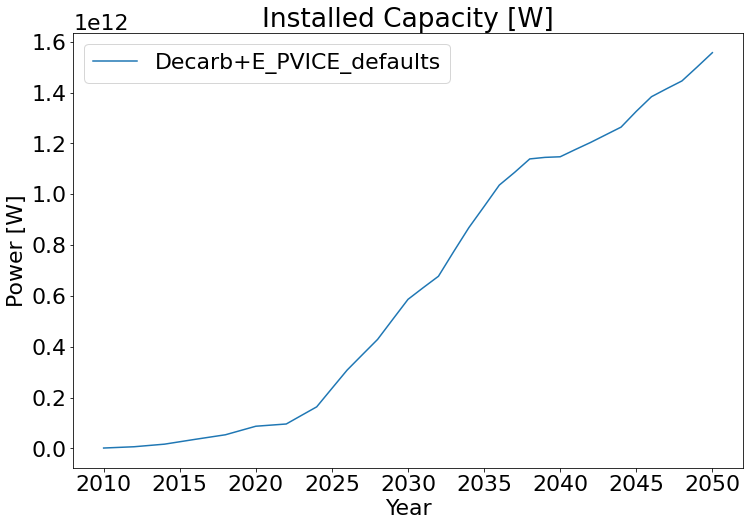

In [21]:
r1.plotScenariosComparison('Installed_Capacity_[W]') 
# leaving the key/argument of this function will print out set of plotting options

## Lifetime and Recycling Scenario Creation

The range of potential future technology directions for PV will be explored in terms of module lifetime and EoL recycling rates. Currently technology is ~32 year module with a 6% EoL recycling rate (15% collection, 40% of collected modules sent to recycling). Lifetimes could improve, with 50 years targeted by DOE SETO, and/or recycling rates could improve, as exemplified by CdTe management from First Solar or perovskite technology. This analysis will explore on a mass flow basis, which of these two circular economy levers (lifetime or recycling) is the most important research priority for achieving the energy transition while minimizing waste and material extraction.

We will explore from a 15 year module lifetime to a 50 year module lifetime, and from 0% recycled to 100% recycled.

### Create lifetime and recycling ranges

In [22]:
Lifetime_Range = pd.concat([pd.Series(range(15,30,3)),pd.Series(range(30,51,2))]) # absolute lifetime values
Lifetime_Range.reset_index(inplace=True, drop=True)
Lifetime_Diff30 = Lifetime_Range-30
Degradation_Range = pd.Series([1.470, 1.220, 1.050, 0.920, 0.820, 0.740, 0.690, 0.650, 0.615, 0.582, 0.555, 0.525, 0.505, 0.480, 0.460, 0.445])
# degradation rates are calculated to be ~80% by the respective lifetime
Recycling_Range = pd.Series(range(0,105,5)) # this is absolute recycling values from 0-100
#print(Lifetime_Range)
#print(Degradation_Range)
#print(Recycling_Range)

In [23]:
#list of material recycling variables
RecyclingPaths = ['mat_MFG_scrap_Recycled', 'mat_MFG_scrap_Recycled_into_HQ', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 
                  'mat_PG4_Recycling_target', 'mat_EOL_Recycled_into_HQ', 'mat_EOL_RecycledHQ_Reused4MFG']
RecyclingYields = ['mat_MFG_scrap_Recycling_eff', 'mat_Recycling_yield']

Automatically generate T50 and T90 values for each lifetime, by creating a linear regression for mod_reliability_t50 & mod_reliability_t90 vs. mod_lifetime to estimate t50 and t90 values to input for various lifetimes.

In [24]:
#first create data frame with the existing lifetimes and T50 and T90 values (which vary with time)
reliability_baselines = pd.DataFrame()
reliability_baselines['mod_lifetime'] = r1.scenario['Decarb+E_PVICE_defaults'].data['mod_lifetime']
reliability_baselines['mod_reliability_t50'] = r1.scenario['Decarb+E_PVICE_defaults'].data['mod_reliability_t50']
reliability_baselines['mod_reliability_t90'] = r1.scenario['Decarb+E_PVICE_defaults'].data['mod_reliability_t90']

In [25]:
X_lifetime = reliability_baselines.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
Y1_t50 = reliability_baselines.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y2_t90 = reliability_baselines.iloc[:, 2].values.reshape(-1, 1)
range_lifetimes = np.array(Lifetime_Range).reshape(-1,1)

from sklearn.linear_model import LinearRegression #pull in tools
from itertools import chain

linear_regressor_Y1 = LinearRegression() #create linear regression
linear_regressor_Y1.fit(X_lifetime, Y1_t50)  # perform linear regression
t50_list = linear_regressor_Y1.predict(range_lifetimes).tolist()  # make predictions based on improved lifetime values
t50_list = list(chain(*t50_list)) #unnest list
t50_range_simple = pd.Series([ '%.2f' % elem for elem in t50_list ]) #pull out the T50 values

linear_regressor_Y2 = LinearRegression() 
linear_regressor_Y2.fit(X_lifetime, Y2_t90)
t90_list = linear_regressor_Y2.predict(range_lifetimes).tolist()
t90_list = list(chain(*t90_list)) #unnest list
t90_range_simple = pd.Series([ '%.2f' % elem for elem in t90_list ]) #pull out the T90 values

In [26]:
#create a tidy dataframe summarizing all the lifetime, degradation, reliability values
lifetime_range_df = pd.concat([Lifetime_Range, Degradation_Range, t50_range_simple, t90_range_simple], axis=1)
lifetime_range_df.columns = 'mod_lifetime', 'mod_degradation', 't50', 't90'
print(lifetime_range_df)
lifetime_range_df.to_csv(os.path.join(testfolder,'Table2-lifeDegT50T90.csv'))

    mod_lifetime  mod_degradation    t50    t90
0             15            1.470  13.95  19.78
1             18            1.220  17.56  23.15
2             21            1.050  21.17  26.53
3             24            0.920  24.78  29.90
4             27            0.820  28.39  33.28
5             30            0.740  32.00  36.65
6             32            0.690  34.41  38.90
7             34            0.650  36.81  41.15
8             36            0.615  39.22  43.40
9             38            0.582  41.63  45.65
10            40            0.555  44.03  47.90
11            42            0.525  46.44  50.15
12            44            0.505  48.85  52.40
13            46            0.480  51.25  54.65
14            48            0.460  53.66  56.90
15            50            0.445  56.07  59.15


In [27]:
#If you want the full list above, do not run this cell. The results indicated little difference for values about 32 years
#drop some of the higher lifetime values due to small value add and graphing
unnecessary = [48,46,42,38,34]
lifetime_range_df = lifetime_range_df[lifetime_range_df.mod_lifetime.isin(unnecessary)==False]
print(lifetime_range_df)

    mod_lifetime  mod_degradation    t50    t90
0             15            1.470  13.95  19.78
1             18            1.220  17.56  23.15
2             21            1.050  21.17  26.53
3             24            0.920  24.78  29.90
4             27            0.820  28.39  33.28
5             30            0.740  32.00  36.65
6             32            0.690  34.41  38.90
8             36            0.615  39.22  43.40
10            40            0.555  44.03  47.90
12            44            0.505  48.85  52.40
15            50            0.445  56.07  59.15


### Create all Scenarios
Now with the lifetime and recycling ranges defined, we will create a PV ICE scenario for each combination

Notes/Assumptions:
- scenario modifictions start in 2020, maintaining historical values and rates
- all recycling is closed loop (i.e. offsets virgin material demand)
- assuming 100% collection of modules and materials
- material recycling yields/efficiency are varied from 0% to 100% in 5% increments

This method simplifies the coding, but can be representative of more complex systems (i.e. 50% collection rate with 80% recycling yield = 40% overall recycling rate.)

In [ ]:
#NOTE: Be patient, this takes a moment
#these scenarios are being added to the r1 simulation with the Decarb+E_PVICE_Default scenario
#All combinations of recycling and lifetime
for life in range(0,len(Lifetime_Range)): #loop over lifetimes
    for recycle in range (0,len(Recycling_Range)): #loop over recycling rates
        scenname = str(Lifetime_Range[life])+'years & '+ str(Recycling_Range[recycle])+'% Recycled' #name the scenario
        r1.createScenario(name=scenname,file=modulefile) #create the scenario with name
        r1.scenario[scenname].addMaterials(MATERIALS) # add all materials listed in MATERIALS
        r1.trim_Years(startYear=2010, endYear=2050)
        #Modify Module flows
        #modify lifetimes
        r1.modifyScenario(scenname, 'mod_lifetime', Lifetime_Range[life], 2020)
        r1.modifyScenario(scenname, 'mod_reliability_t50', float(t50_range_simple[life]), 2020)
        r1.modifyScenario(scenname, 'mod_reliability_t90', float(t90_range_simple[life]), 2020)
        r1.modifyScenario(scenname, 'mod_degradation', Degradation_Range[life], 2020)
        #set module collection to 100%
        r1.modifyScenario(scenname, 'mod_EOL_collection_eff', 100.0, 2020)
        #modify path good to ensure everything goes to recycling
        r1.modifyScenario(scenname, 'mod_EOL_pg0_resell', 0.0, 2020)
        r1.modifyScenario(scenname, 'mod_EOL_pg2_stored', 0.0, 2020)
        r1.modifyScenario(scenname, 'mod_EOL_pg3_reMFG', 0.0, 2020)
        r1.modifyScenario(scenname, 'mod_EOL_pg4_recycled', 100.0, 2020)#all good status modules go to recycling
        r1.modifyScenario(scenname, 'mod_EOL_sp_reMFG_recycle', 100.0, 2020) #just in case
        #modify path bad to ensure everything goes to recycling
        r1.modifyScenario(scenname, 'mod_EOL_pb2_stored', 0.0, 2020)
        r1.modifyScenario(scenname, 'mod_EOL_pb3_reMFG', 0.0, 2020)
        r1.modifyScenario(scenname, 'mod_EOL_pb4_recycled', 100.0, 2020)#all bad status modules go to recycling
        
        #Modify Material flows
        #set all material recycling paths to 100%, this directs everything to closed loop recycling
        for var in range(0,len(RecyclingPaths)): #reMFG is 0.0 by default rn
            r1.scenario[scenname].modifyMaterials(MATERIALS, stage=RecyclingPaths[var], value=100.0, start_year=2020)
        
        #set material recycling yields to the variable rates 0% to 100%
        for ylds in range(0,len(RecyclingYields)):
            r1.scenario[scenname].modifyMaterials(MATERIALS, stage=RecyclingYields[ylds], value=Recycling_Range[recycle], start_year=2020)

In [ ]:
#Check some scenario dataframes
#r1.scenario['Decarb+E_PVICE_defaults'].data.head(15)
#r1.scenario['15years & 0% Recycled'].data.head(15)
#r1.scenario['50years & 0% Recycled'].data.head(15)
#r1.scenario['50years & 0% Recycled'].material['glass'].materialdata.head(15)

In [ ]:
print('There are a total of ' + str(len(r1.scenario.keys())) + 'scenarios, including the PV ICE Baseline.')

Now we run the scenarios. This run of the simulation uses identical installations (i.e. no replacements)

In [ ]:
r1.calculateMassFlow()

In [ ]:
r1.plotScenariosComparison('Installed_Capacity_[W]')

In [ ]:
r1.plotMaterialComparisonAcrossScenarios(material='glass', keyword='mat_Total_Landfilled')

Use the PV ICE "aggregate results" function to print out a table of Virgin Material Demands, Lifecycle Wastes (MFG, EoL, both), new installed capacity and effective cumulative capacity, both annually and cumulatively.

In [ ]:
#assign two variables to be the dataframe outputs of this function
yearlyRvL_identinstall, cumRvL_identinstall = r1.aggregateResults() 
#yearlyRvL_identinstall.tail(5)

In [ ]:
#save these dataframes to csv files
yearlyRvL_identinstall.to_csv(os.path.join(testfolder,'yearlyRvL-identinstall.csv'))
cumRvL_identinstall.to_csv(os.path.join(testfolder,'cumulativeRvL-identinstall.csv'))

Read the aggregated results back into the journal from csvs (run time on simulations can be long)

In [ ]:
yearlyRvL_identinstall = pd.read_csv(os.path.join(testfolder,'yearlyRvL-identinstall.csv'), index_col='year')
cumRvL_identinstall = pd.read_csv(os.path.join(testfolder,'cumulativeRvL-identinstall.csv'), index_col='year')

### Figure 2 
Here we select the data for figure 2. This is done by selecting a single column example of each lifetime, adding the PV ICE baseline, selecting for the effective capacity column, and printing to csv for graphing. 

Recycling rate doesn't have an effect on effective capacity, only on the virgin material demand and lifecycle wastes, therefore we can select a single lifetime example and it doesn't matter which recycling rate it is.

In [ ]:
singleLifeset = yearlyRvL_identinstall.filter(like='95%') #select a single lifetime of each
PVICEset = yearlyRvL_identinstall.filter(like='PVICE_defaults') #pvice baseline
singleLifesetfull = pd.concat([PVICEset,singleLifeset], axis=1) #combine
singleLifeActiveCap = singleLifesetfull.filter(regex='^ActiveCapacity') #select for effective capacity
singleLifeActiveCap.to_csv('fig2-identicalinsalls-activecapacity.csv')

In [ ]:
#simple version of Figure 2
plt.plot(singleLifeActiveCap)

Heat Map - Identical Installs

This Heatmap is not used in the publication. There are two graphs, virgin material demand and life cycle wastes. The X-axis is module lifetime and the y-axis is Recycling Rate. The colors are relative to the virgin material demand and life cycle wastes of the PV ICE Baseline. These graphs are for identical installations, meaning that shorter lifetime scenarios do not meet energy transition capacity targets

In [ ]:
#make a dataframe to become the multiIndex for heat map creation
lifeRecycIndex = pd.DataFrame(columns = ['Life','Recycling'])
for life in range(0,len(Lifetime_Range)): #loop over lifetimes
    for recycle in range (0,len(Recycling_Range)): #loop over recycling rates
        toappend = pd.DataFrame([[Lifetime_Range[life],Recycling_Range[recycle]]], columns=('Life', 'Recycling'))
        lifeRecycIndex = pd.concat([lifeRecycIndex, toappend])
pvice_index = pd.DataFrame([['pvice','pvice']], columns=('Life', 'Recycling'))
lifeRecycIndex_complete = pd.concat([pvice_index,lifeRecycIndex])

In [ ]:
#ii = indentical installs
#manipulate dataframes for the heat map form, waste & virgin
heatmap_cums = cumRvL_identinstall.copy()
#filter down to "waste all module" and "virgin stock module"
heatmap_cums_modulewaste = heatmap_cums.filter(regex='WasteAll_Module')
heatmap_cums_virgindemand = heatmap_cums.filter(regex='VirginStock_Module')

#Combine the multi index and heatmap data
#transpose the dataframe, moving columns to the index
heatmap_cums_modulewaste_twist = heatmap_cums_modulewaste.T 
heatmap_cums_virgindemand_twist = heatmap_cums_virgindemand.T
#Wastes
lifeRecycIndex_complete.index= heatmap_cums_modulewaste_twist.index #make index match for join
module_waste_heatmapdata = lifeRecycIndex_complete.join(heatmap_cums_modulewaste_twist) #join dataframes
module_waste_heatmapdata.set_index(['Life','Recycling'], inplace=True) #create multi index for unstacking
#Virgin demands
lifeRecycIndex_complete.index= heatmap_cums_virgindemand_twist.index #make index match for join
virgin_material_heatmapdata = lifeRecycIndex_complete.join(heatmap_cums_virgindemand_twist) #join dataframes
virgin_material_heatmapdata.set_index(['Life','Recycling'], inplace=True) #create multi index for unstacking

#create subset data of just 2050 cumulative wastes
modulewaste_heatmap_tonnes = pd.DataFrame(module_waste_heatmapdata[2050]) #select only 2050 cumulative values
modulewaste_heatmap = modulewaste_heatmap_tonnes/1e6 #convert to million metric tonnes
heatdata_Waste_pivot_orig = modulewaste_heatmap.unstack(level=0) #compare recycling vs lifetime
heatdata_Waste_pivot_ii = heatdata_Waste_pivot_orig[::-1] #reverse the order of recycling rate

#create subset data of just 2050 cumulative virgin demands
virgin_mat_demand_tonnes = pd.DataFrame(virgin_material_heatmapdata[2050]) #select only 2050 - need to improve to remove label
virgin_mat_demand = virgin_mat_demand_tonnes/1e6 #convert to million metric tonnes
heatdata_virgin_pivot_orig = virgin_mat_demand.unstack(level=0) #pivot
heatdata_Virgin_pivot_ii = heatdata_virgin_pivot_orig[::-1] #reverse order of recycling rate

In [ ]:
print('Minimum waste is '+str(round(np.min(heatdata_Waste_pivot_ii).min(),0))+' million metric tonnes')
print('Maximum waste is '+str(round(np.max(heatdata_Waste_pivot_ii).max(),0))+' million metric tonnes')
print('Minimum virgin is '+str(round(np.min(heatdata_Virgin_pivot_ii).min(),0))+' million metric tonnes')
print('Maximum virgin is '+str(round(np.max(heatdata_Virgin_pivot_ii).max(),0))+' million metric tonnes')


In [ ]:
#Make heat maps with cumulative data
import seaborn as sns
plt.style.use("seaborn")

#plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (10, 18)
fig,ax = plt.subplots(2, 1)
sns.set(font_scale=1.5)
color = plt.get_cmap('coolwarm')
color.set_bad('white')

#Wastes
plt.subplot(2,1,1)
sns.heatmap(heatdata_Waste_pivot_ii, annot = False, 
            cmap='coolwarm', #sns.diverging_palette(220, 20, n=200), 
            vmin= 0.0, #(np.min(heatdata_Waste_pivot_ii).min()),
            vmax= 100.0, #(np.max(heatdata_Waste_pivot_ii).max()),  #using same scale as cc below
            center = 8.3 , #fix to be dynamic finding pvice value
            cbar_kws={'label': 'Lifecycle Wastes by 2050 [Million Metric Tonnes]'})
plt.title('Lifecycle Wastes')
plt.ylabel('Recycling Rate (%)')
plt.xlabel('Lifetime (years)')
plt.yticks(rotation=0)
#plt.xticks(fontsize=14)
#

#Virgin Demands
plt.subplot(2,1,2)
sns.heatmap(heatdata_Virgin_pivot_ii, annot = False,
           cmap='coolwarm', #sns.diverging_palette(220, 20, n=200), 
            vmin= 20.0, #(np.min(heatdata_Virgin_pivot_ii).min()),
            vmax= 180.0, #(np.max(heatdata_Virgin_pivot_ii).max()), #using max cc below
            center=96.685293, #fix to be dynamic
           cbar_kws={'label': 'Virgin Material Demands by 2050 [Million Metric Tonnes]'})
plt.title('Virgin Demands')
plt.ylabel('Recycling Rate (%)')
plt.xlabel('Lifetime (years)')
plt.yticks(rotation=0)
#plt.xticks(fontsize=14)

#Installed Capacity
#plt.subplot(3,1,3)
#sns.heatmap(heatdata_InstalledCap_pivot, annot = False,
#           cmap=sns.diverging_palette(20, 220, n=200), 
#            vmin=-70.0, vmax=10.0, center=0, square=True)
#plt.title('Installed Capacity')
#plt.xlabel('Recycling Rate')
#plt.yticks(rotation=0)

fig.suptitle('2050 Cumulative Wastes and Material Demands:\n Identical Installs', fontsize=22, x=0.45)
plt.subplots_adjust(top=0.9)
fig.tight_layout(h_pad=1)
# set the spacing between subplots
#plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)


plt.savefig('heatmap-identicalInstalls.png')
plt.show()

### Figure 7 Pie Charts
Printing out the data for pie chart of cumulative Virgin Material Demands and Lifecycle Wastes in 2050, PV ICE scenario

In [ ]:
pvice_cums = cumRvL_identinstall.filter(like='Decarb+E_PVICE_defaults')
pvice_cumwastes = pvice_cums.filter(regex='WasteAll')
pvice_2050_cumwastes = pd.DataFrame(pvice_cumwastes.loc[2050])
pvice_2050_cumwastes.to_csv(os.path.join(testfolder,'PVICE_cumulativeWastes2050_pieChart.csv'))

## Installation with Replacements - Compensation Calculation

This section of the analysis runs the capacity compensation simulation. For each scenario, each year the deployment "new installed capacity" is adjusted (up for short-lived modules or down for long-lived modules) by the difference in effective capacity between the scenario and the PV ICE Baseline effective capacity. 

NOTE: this mass flow calculation takes a LONG time to run, recommend leaving it overnight. A csv of the yearly and cumulative aggregated results is saved as csv and read back in to speed analysis and graphing.

In [ ]:

for row in range (0,len(r1.scenario['Decarb+E_PVICE_defaults'].data)):
    for scenario in range (0, len(r1.scenario.keys())):
        scen = list(r1.scenario.keys())[scenario]
        Under_Installment = ( (r1.scenario['Decarb+E_PVICE_defaults'].data['Installed_Capacity_[W]'][row] - 
                               r1.scenario[scen].data['Installed_Capacity_[W]'][row])/1000000 )  # MWATTS
        r1.scenario[scen].data['new_Installed_Capacity_[MW]'][row] += Under_Installment
    r1.calculateMassFlow()


In [ ]:
yearlyRvL_installcomp, cumRvL_installcomp = r1.aggregateResults()
yearlyRvL_installcomp.to_csv(os.path.join(testfolder,'yearlyRvL-installcomp.csv'))
cumRvL_installcomp.to_csv(os.path.join(testfolder,'cumulativeRvL-installcomp.csv'))

Read the csvs back in for plotting (installation compensation calc runs a LONG time).

In [ ]:
yearlyRvL_installcomp = pd.read_csv(os.path.join(testfolder,'yearlyRvL-installcomp.csv'), index_col='year')
cumRvL_installcomp = pd.read_csv(os.path.join(testfolder,'cumulativeRvL-installcomp.csv'), index_col='year')

### Figure 3
Bar chart of additional installations

In [ ]:
singleLifeRange = cumRvL_installcomp.filter(like='95%') #select a single lifetime of each
newinstallsedofSingleLifeRange = singleLifeRange.filter(regex='newInstalledCapacity') #select for new installs
LifeRange_installsComped = pd.DataFrame(newinstallsedofSingleLifeRange.loc[2050]) #select only the 2050 cumulatives
LifeRange_installsComped.set_index(Lifetime_Range, inplace=True) #set the index to the lifetime range for label ease
LifeRange_installsComped_TW = LifeRange_installsComped/1e6 #convert to TW

pvice_newinstalls = cumRvL_installcomp.filter(like='newInstalledCapacity_SF-LvR_Decarb+E_PVICE_defaults')
pvice_newinstalls_2050 = pvice_newinstalls.loc[2050].values
pvice_newinstalls_TW = pvice_newinstalls_2050/1e6
#pvice_newinstalls_TW.columns = LifeRange_installsComped_TW.columns
LifeRange_installsComped_TW_relative = LifeRange_installsComped_TW-pvice_newinstalls_TW

LifeRange_installsComped_TW_relative.to_csv(os.path.join(testfolder,'AddedReqInstalls-BarChartData.csv'))

In [ ]:
LifeRange_installsComped_TW_relative.plot(kind='bar')

### Figure 4 Heat Maps with Replacements

This creates the data frames and heat maps of virgin material demand and lifecycle wastes for all 336 scenarios, including replacement modules. Colors are relative to the PV ICE baseline.

In [ ]:
#cc = compensated capacity
#manipulate dataframes for the heat map form, waste & virgin
heatmap_cums_cc = cumRvL_installcomp.copy()
#filter down to "waste all module"
heatmap_cums_modulewaste_cc = heatmap_cums_cc.filter(regex='WasteAll_Module')
heatmap_cums_virgindemand_cc = heatmap_cums_cc.filter(regex='VirginStock_Module')

#Combine the multi index and heatmap data
heatmap_cums_modulewaste_twist_cc = heatmap_cums_modulewaste_cc.T #transpose the dataframe
heatmap_cums_virgindemand_twist_cc = heatmap_cums_virgindemand_cc.T

#create subset data of just 2050 cumulative wastes
lifeRecycIndex_complete.index= heatmap_cums_modulewaste_twist_cc.index #make index match for join
module_waste_heatmapdata_cc = lifeRecycIndex_complete.join(heatmap_cums_modulewaste_twist_cc) #join dataframes
module_waste_heatmapdata_cc.set_index(['Life','Recycling'], inplace=True) #create multi index for unstacking
modulewaste_heatmap_tonnes_cc = pd.DataFrame(module_waste_heatmapdata_cc[2050]) #select only 2050 cumulative values
modulewaste_heatmap_cc = modulewaste_heatmap_tonnes_cc/1e6 #convert to million metric tonnes
heatdata_Waste_pivot_orig_cc = modulewaste_heatmap_cc.unstack(level=0) #compare recycling vs lifetime
heatdata_Waste_pivot_cc_dropcol = heatdata_Waste_pivot_orig_cc[::-1] #reverse the order of recycling rate
heatdata_Waste_pivot_cc = heatdata_Waste_pivot_cc_dropcol.iloc[1:,:-1] #remove pvice col
heatdata_Waste_pivot_cc.columns = heatdata_Waste_pivot_cc.columns.droplevel(0) #remove 2050 from label

#create subset data of just 2050 cumulative virgin demands
lifeRecycIndex_complete.index= heatmap_cums_virgindemand_twist_cc.index #make index match for join
virgin_material_heatmapdata_cc = lifeRecycIndex_complete.join(heatmap_cums_virgindemand_twist_cc) #join dataframes
virgin_material_heatmapdata_cc.set_index(['Life','Recycling'], inplace=True) #create multi index for unstacking
virgin_mat_demand_tonnes_cc = pd.DataFrame(virgin_material_heatmapdata_cc.loc[:,2050]) #select only 2050 - need to improve to remove label
virgin_mat_demand_cc = virgin_mat_demand_tonnes_cc/1e6 #convert to million metric tonnes
heatdata_virgin_pivot_orig_cc = virgin_mat_demand_cc.unstack(level=0)
heatdata_Virgin_pivot_cc_dropcol = heatdata_virgin_pivot_orig_cc[::-1] #reverse order of recycling rate
heatdata_Virgin_pivot_cc = heatdata_Virgin_pivot_cc_dropcol.iloc[1:,:-1] #removes pvice column from recycling rate
heatdata_Virgin_pivot_cc.columns=heatdata_Virgin_pivot_cc.columns.droplevel(0) #remove 2050 from label

First, pull out the material demand and wastes for the PV ICE Baseline

In [ ]:
#virgin material demand
virgin_mat_demand_cc.loc['pvice'] # = virgin_mat_demand.loc['pvice'] THEY ARE THE SAME

In [ ]:
#lifecycle wastes
modulewaste_heatmap_cc.loc['pvice'] 

In [ ]:
#this defines the upper and lower bounds for the color map
print('Minimum waste is '+str(round(np.min(heatdata_Waste_pivot_cc).min(),2))+' million metric tonnes')
print('Maximum waste is '+str(round(np.max(heatdata_Waste_pivot_cc).max(),0))+' million metric tonnes')
print('Minimum virgin is '+str(round(np.min(heatdata_Virgin_pivot_cc).min(),0))+' million metric tonnes')
print('Maximum virgin is '+str(round(np.max(heatdata_Virgin_pivot_cc).max(),0))+' million metric tonnes')


In [ ]:
print('Minimum Virgin demand for compensated capacity is '
      +str(round(np.min(virgin_mat_demand_cc).min(),2))+' million metric tonnes'+
     ' for scenario (Life,Recycling) '+ str(virgin_mat_demand_cc.idxmin()))

In [ ]:
print('Maximum Virgin demand for compensated capacity is '
      +str(round(np.max(virgin_mat_demand_cc).max(),2))+' million metric tonnes'+
     ' for scenario (Life,Recycling) '+ str(virgin_mat_demand_cc.idxmax()))

In [ ]:
#Make heat maps with cumulative data
import seaborn as sns
plt.style.use("seaborn")

#plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (10, 18)
fig,ax = plt.subplots(2, 1)
sns.set(font_scale=1.5)

mask_virgin = (heatdata_Virgin_pivot_cc > 95) & (heatdata_Virgin_pivot_cc < 99) # 96.685293
mask_waste = (heatdata_Waste_pivot_cc > 6) & (heatdata_Waste_pivot_cc < 10) #8.330916

#Virgin Demands
plt.subplot(2,1,1)
axx = sns.heatmap(heatdata_Virgin_pivot_cc, annot = False,
           cmap= sns.diverging_palette(255,0, s=100, sep=1, n=60), 
            vmin= 80.0 ,#(round(np.min(heatdata_Virgin_pivot_cc).min(),0)), 
            vmax= (round(np.max(heatdata_Virgin_pivot_cc).max(),-1)),
            center=96.685293, #fix to be dynamic
           cbar_kws={'label': 'Cumulative by 2050 [Million Metric Tonnes]'},
           mask = mask_virgin)
plt.title('Virgin Demands', fontsize=20)
plt.ylabel('Recycling Rate [%]', fontsize=20)
plt.xlabel('Lifetime (years)', fontsize=20)
plt.yticks(rotation=0)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
axx.set_facecolor("white")
axx.patch.set(hatch='x', edgecolor='aliceblue')
#Wastes
plt.subplot(2,1,2)
axy = sns.heatmap(heatdata_Waste_pivot_cc, annot = False, 
            cmap= sns.diverging_palette(220, 20, s=100,sep=1, n=60), 
            vmin= 0.0, #(round(np.min(heatdata_Waste_pivot_cc).min(),0)), 
            vmax= (round(np.max(heatdata_Waste_pivot_cc).max(),-1)), 
            center = 8.330916 , #fix to be dynamic finding pvice value
            cbar_kws={'label': 'Cumulative by 2050 [Million Metric Tonnes]'},
            mask = mask_waste)
plt.title('Lifecycle Wastes', fontsize=20)
plt.ylabel('Recycling Rate [%]', fontsize=20)
plt.xlabel('Lifetime (years)', fontsize=20)
plt.yticks(rotation=0)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
axy.set_facecolor("white")
axy.patch.set(hatch='x', edgecolor='ghostwhite')
#

fig.suptitle('2050 Cumulative Material Demands and Lifeycle Wastes:\n With Replacements', fontsize=22, x=0.45)
plt.subplots_adjust(top=0.9)
fig.tight_layout(h_pad=1)
# set the spacing between subplots
#plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)

plt.savefig('fig4.tif', dpi=300)
plt.show()

### Figure 5 - Time Shifted Demand and Wastes

This code exports the data for Figure 5. The 0% recycling scenario is selected to represent the full material demand (since all other recycling scenarios offset the virgin material demand with recycled content). This allows comparison of overall material demands, and a visualization of how much of the lifecycle wastes could offset demand and when.

In [ ]:
#select out the 15 year, 0% recycling data and pv ice data
data15yr = yearlyRvL_installcomp.filter(regex = r'(15years & 0%)')
datapvice = yearlyRvL_installcomp.filter(regex = 'PVICE')
fig5data_annual = pd.concat([datapvice,data15yr], axis=1)
fig5data_annual_module = fig5data_annual.filter(regex='Module')
#sum each 5 year increment
#fig5data_annual_module.to_csv(os.path.join(testfolder,'fig5-annualdata.csv')) #annual as sanity check
#groups the index by 5s, this leaves 2050 dangling, just add it in to 2045-2050
fig5data = fig5data_annual_module.groupby(np.arange(len(fig5data_annual))//5).sum() 
fig5data.to_csv(os.path.join(testfolder,'fig5-5yrdata.csv'))

### Table 1 - Select results

Print out table 1 select results for virgin material demand and lifecycle wastes.

In [ ]:
heatdata_Virgin_pivot_cc.loc[[0,50,90,95,100],[15,30,50]]

In [ ]:
heatdata_Waste_pivot_cc.loc[[0,50,90,95,100],[15,30,50]]

# Sanity Check: BOM decrease and Efficiency increase

These results were presented at PVRW 2022.

## BOM modification

First method of approximating a "thin film" BOM as just glass, backsheet, an Aluminum Frame. This is similar to CdTe modules. A second method of reducing mass to thin film design is presented below.

In [ ]:
thinfilmMaterials = ['glass','backsheet','aluminium_frames']
#create a subset of 15 year module with all recycling values
life15 = lifetime_range_df.iloc[0,:]

In [ ]:
r3 = PV_ICE.Simulation(name='SanityCheck', path=testfolder) #create simulation 
#baselinefolder = r'..\baselines'    

for scen in range(len(SFscenarios)):
    modulefile = SFscenarios[scen]+'.csv' #pick the scenario csv
    modulefile = os.path.join(testfolder, 'USA', modulefile) #point at the file path for the whole US
    r3.createScenario(name='Decarb+E_PVICE_defaults', file=modulefile) #change name=SFscenarios[scen] if multiple scenarios
    r3.scenario['Decarb+E_PVICE_defaults'].addMaterials(thinfilmMaterials)  # add materials
    r3.trim_Years(startYear=2010)

In [ ]:
for recycle in range (0,len(Recycling_Range)): #loop over recycling rates
    scenname = 'ThinFilm 15 years & '+ str(Recycling_Range[recycle])+'% Recycled' #name the scenario
    r3.createScenario(name=scenname,file=modulefile) #create the scenario with name
    r3.scenario[scenname].addMaterials(thinfilmMaterials)  # baselinefolder=baselinefolder)
    r3.trim_Years(startYear=2010, endYear=2050)
    r3.modifyScenario(scenname, 'mod_lifetime', 15, 2020)
    r3.modifyScenario(scenname, 'mod_reliability_t50', float(life15['t50']), 2020)
    r3.modifyScenario(scenname, 'mod_reliability_t90', float(life15['t90']), 2020)
    r3.modifyScenario(scenname, 'mod_degradation', life15['mod_degradation'], 2020)
    r3.modifyScenario(scenname, 'mod_EOL_collected_recycled', 100.0, 2020)
    r3.modifyScenario(scenname, 'mod_EOL_collection_eff', 100.0, 2020)
        
    for var in range(0,len(RecyclingPaths)):
        r3.scenario[scenname].modifyMaterials(thinfilmMaterials, stage=RecyclingPaths[var], value=100.0, start_year=2020)
        
    for ylds in range(0,len(RecyclingYields)):
        r3.scenario[scenname].modifyMaterials(thinfilmMaterials, stage=RecyclingYields[ylds], 
                                                  value=Recycling_Range[recycle], start_year=2020)

In [ ]:
r3.calculateMassFlow()

In [ ]:
r3.plotScenariosComparison('Installed_Capacity_[W]')

In [ ]:
r3.plotMaterialComparisonAcrossScenarios(material='glass', keyword='mat_Total_Landfilled')

In [ ]:
yearlythinfilmresults, cumthinfilmresults = r3.aggregateResults()
yearlythinfilmresults.to_csv(os.path.join(testfolder,'yearlythinfilmresults.csv'))
cumthinfilmresults.to_csv(os.path.join(testfolder,'cumthinfilmresults.csv'))

Now calculate installation compensation for the 15 year module.

In [ ]:
for row in range (0,len(r3.scenario['Decarb+E_PVICE_defaults'].data)):
    for scenario in range (0, len(r3.scenario.keys())):
        scen = list(r3.scenario.keys())[scenario]
        Under_Installment = ( (r3.scenario['Decarb+E_PVICE_defaults'].data['Installed_Capacity_[W]'][row] - 
                               r3.scenario[scen].data['Installed_Capacity_[W]'][row])/1000000 )  # MWATTS
        r3.scenario[scen].data['new_Installed_Capacity_[MW]'][row] += Under_Installment
    r3.calculateMassFlow()

In [ ]:
yearlythinfilmresults_cc, cumthinfilmresults_cc = r3.aggregateResults()
yearlythinfilmresults_cc.to_csv(os.path.join(testfolder,'yearlythinfilmresults_cc.csv'))
cumthinfilmresults_cc.to_csv(os.path.join(testfolder,'cumthinfilmresults_cc.csv'))

In [ ]:
r3.plotScenariosComparison('Installed_Capacity_[W]')

Search for the cumulative value that is less/more than the PV ICE baseline with all materials.

In [ ]:
#PV ICE all materials values
PVICE_virgin = cumRvL_identinstall.loc[2050]['VirginStock_Module_SF-LvR_Decarb+E_PVICE_defaults_[Tonnes]']/1e6
PVICE_waste = cumRvL_identinstall.loc[2050]['WasteAll_Module_SF-LvR_Decarb+E_PVICE_defaults_[Tonnes]']/1e6

print('PV ICE Baseline Values: \nVirgin Material Demand '
      +str(round(PVICE_virgin,2))+' million metric tonnes\n'+
     'Lifecycle Waste '+ str(round(PVICE_waste,2)) + ' million metric tonnes')

In [ ]:
thinfilm_virginmod = pd.DataFrame(cumthinfilmresults_cc.loc[2050].filter(like='VirginStock_Module'))
thinfilm_virginmod[::-1]>=PVICE_virgin*1e6

Here, we compare the PV ICE c-Si virgin material demand to a thin film of 15 year life. These results indicate that lowering the BOM will lower the required closed-loop recycling rate to reduce virgin material demands from 95% to 75%.

In [ ]:
thinfilm_waste = pd.DataFrame(cumthinfilmresults_cc.loc[2050].filter(like='WasteAll_Module'))
thinfilm_waste[::-1]>=PVICE_waste*1e6

This compares the thin film BOM waste to the PV ICE c-Si baseline waste. The recyling requirement for lowering waste is still quite high. Given that most of the waste is attributable to pre-2020 low open-loop recycleable modules, little can be done about the pre 2050 waste.

## Efficiency Modifcation

Now that we have confirmed that decreasing the mass per module area will lower the required closed-loop recycling rate, lets check that increasing module efficiency will have the same effect. Currently, PV ICE baseline is 20% efficiency in 2020 and 25% efficient in 2050. Oberbeck et al 2020 expect 30% efficient tandem devices (perovskite + silicon). Therefore, we will use this as an approximation of an efficiency increase, and will apply it to the 15 year module.

In [ ]:
#create a subset of 15 year module with all recycling values
life15 = lifetime_range_df.iloc[0,:]

In [ ]:
reff = PV_ICE.Simulation(name='SanityCheck', path=testfolder) #create simulation r1
#baselinefolder = r'..\baselines'    

for scen in range(len(SFscenarios)):
    modulefile = SFscenarios[scen]+'.csv' #pick the scenario csv
    modulefile = os.path.join(testfolder, 'USA', modulefile) #point at the file path for the whole US
    reff.createScenario(name='Decarb+E_PVICE_defaults', file=modulefile) #change name=SFscenarios[scen] if multiple scenarios
    reff.scenario['Decarb+E_PVICE_defaults'].addMaterials(MATERIALS)  # baselinefolder=baselinefolder)
    reff.trim_Years(startYear=2010)

In [ ]:
for recycle in range (0,len(Recycling_Range)): #loop over recycling rates
    scenname = 'Tandem 15 years & '+ str(Recycling_Range[recycle])+'% Recycled' #name the scenario
    reff.createScenario(name=scenname,file=modulefile) #create the scenario with name
    reff.scenario[scenname].addMaterials(MATERIALS)  # baselinefolder=baselinefolder)
    reff.trim_Years(startYear=2010, endYear=2050)
    reff.modifyScenario(scenname, 'mod_lifetime', 15, 2020)
    reff.modifyScenario(scenname, 'mod_reliability_t50', float(life15['t50']), 2020)
    reff.modifyScenario(scenname, 'mod_reliability_t90', float(life15['t90']), 2020)
    reff.modifyScenario(scenname, 'mod_degradation', life15['mod_degradation'], 2020)
    reff.modifyScenario(scenname, 'mod_EOL_collected_recycled', 100.0, 2020)
    reff.modifyScenario(scenname, 'mod_EOL_collection_eff', 100.0, 2020)
    reff.modifyScenario(scenname, 'mod_eff', 30.0, 2020)
        
    for var in range(0,len(RecyclingPaths)):
        reff.scenario[scenname].modifyMaterials(MATERIALS, stage=RecyclingPaths[var], value=100.0, start_year=2020)
        
    for ylds in range(0,len(RecyclingYields)):
        reff.scenario[scenname].modifyMaterials(MATERIALS, stage=RecyclingYields[ylds], 
                                                  value=Recycling_Range[recycle], start_year=2020)

In [ ]:
baselineeff = reff.scenario['Decarb+E_PVICE_defaults'].data['mod_eff']
tandemeff = reff.scenario['Tandem 15 years & 0% Recycled'].data['mod_eff']

mod_eff_compare_t = pd.DataFrame([baselineeff,tandemeff])
mod_eff_compare = mod_eff_compare_t.T
mod_eff_compare.index=range(2010,2051)
mod_eff_compare.columns = ('PV ICE','High Efficiency')
plt.plot(mod_eff_compare)
plt.title('Module Efficiency Comparison')
plt.legend(mod_eff_compare.columns)
plt.ylabel('Module Efficiency [%]')

In [ ]:
reff.calculateMassFlow()

In [ ]:
for row in range (0,len(reff.scenario['Decarb+E_PVICE_defaults'].data)):
    for scenario in range (0, len(reff.scenario.keys())):
        scen = list(reff.scenario.keys())[scenario]
        Under_Installment = ( (reff.scenario['Decarb+E_PVICE_defaults'].data['Installed_Capacity_[W]'][row] - 
                               reff.scenario[scen].data['Installed_Capacity_[W]'][row])/1000000 )  # MWATTS
        reff.scenario[scen].data['new_Installed_Capacity_[MW]'][row] += Under_Installment
    reff.calculateMassFlow()

In [ ]:
yearly_higheff_cc, cum_higheff_cc = reff.aggregateResults()
yearly_higheff_cc.to_csv(os.path.join(testfolder,'yearly_higheff_cc.csv'))
cum_higheff_cc.to_csv(os.path.join(testfolder,'cum_higheff_cc.csv'))

First we check the change in deployed capacity, since modifying module efficiency will primarily effect the deployment (and as a result effect virgin mateiral demand). Installs are only dependent on life, not recycling, therefore we can select any of the recycling rates.

In [ ]:
reff.plotScenariosComparison('Area')

Because we deploy using MW, the difference from efficiency improvement will not appear in MW deployed but in the area of those MW deployed. Therefore, we will compare the area deployed as a proxy for # of modules and compare the tandem 30% efficiency against the c-Si 25% efficiency 15 year modules, and PV ICE.

In [ ]:
#'Area' is what gets installed annually, so cumcum = sum area installed
tandem_annualareainstalled = pd.Series(reff.scenario['Tandem 15 years & 0% Recycled'].data['Area'])
tandem_cumareainstalled = pd.Series(tandem_annualareainstalled.cumsum())

PVICE_annualareainstalled = pd.Series(reff.scenario['Decarb+E_PVICE_defaults'].data['Area'])
PVICE_cumareainstalled = PVICE_annualareainstalled.cumsum()

#the area deployed for the 15 yr BOM modified will be the same as the main analysis, because the eff is the same
#therefore, use r3 to get this number
cSi15yr_annualareainstalled = pd.Series(r3.scenario['ThinFilm 15 years & 0% Recycled'].data['Area'])
cSi15yr_cumareainstalled = cSi15yr_annualareainstalled.cumsum()

areacompare = pd.DataFrame([tandem_cumareainstalled, PVICE_cumareainstalled, cSi15yr_cumareainstalled], 
             index=['15-yr High Efficiency','PV ICE','15-yr c-Si'])
areacompare_df = areacompare.T
areacompare_df.index=range(2010,2051)

plt.plot(areacompare_df)
plt.legend(areacompare_df.columns)
plt.title('Cumulative Area Deployed')
plt.ylabel('Area Deployed [m^2]')

Area comparison

In [ ]:
#Make a pretty chart to compare areas vs landmarks
areacompare_km = areacompare_df/1e6
areacompare_km_graphing = pd.DataFrame(areacompare_km.loc[2050])
areacompare_km_graphing.columns=['Area km^2']
otherland = pd.DataFrame({'Area km^2':[8991,14357,6446]}, 
                         index=['Yellowstone','Connecticut','Delaware'])
areacompare_km_graph = areacompare_km_graphing.append(otherland)
areacompare_km_graph_rnd = round(areacompare_km_graph,0)
areacompare_km_graph_sorted = areacompare_km_graph_rnd.sort_values('Area km^2', ascending=False)
areacompare_km_graph_sorted

In [ ]:
# import the circlify library
import circlify

# compute circle positions:
circles = circlify.circlify(
    areacompare_km_graph_sorted['Area km^2'].tolist(), 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(11,11))

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# print circles
for circle in circles:
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2, edgecolor='black', fill=False))

If we approximate a module as 2 m^2 (current average, though CdTe series 6 modules are 2.47 m^2), then we can use the area deployed to calculate an approximate number of modules.

In [ ]:
modulesdeployed_billions = (areacompare_df/2)/1e9
modulesdeployed_billions.tail(1)

In [ ]:
reducedmodules = modulesdeployed_billions.loc[2050,'c-Si 15yr']-modulesdeployed_billions.loc[2050,'15 yr Tandem']
modulesvspvice = modulesdeployed_billions.loc[2050,'15 yr Tandem']-modulesdeployed_billions.loc[2050,'PV ICE']
print('If module eff is 30%, then '+str(round(reducedmodules,2))+' billion fewer modules can be deployed.')
print('However, the 15 year 30% effcient module still requires '+str(round(modulesvspvice,2))+
      ' billion more modules than the 35 year 25% efficient module.')


This graph shows the cumulative deployed area over time for the PV ICE baseline, the "15-year Tandem" device, which is the same BOM but higher module efficiency (30%), and the c-Si 15 year module with the same efficiency as PV ICE (25%). We see that the higher efficiency lowers the required deployment area. Interestingly, around 2038, PV ICE and the 15-year Tandem device cross, because the replacement requirement for the 15-year Tandem is higher than PV ICE 35 year module. Cumulatively, the Tandem device still requires more area deployment. Next let's look at what level of closed-loop recycling will drop the virgin material requirements.

In [ ]:
tandem_virginmod = pd.DataFrame(cum_higheff_cc.loc[2050].filter(like='VirginStock_Module'))
tandem_virginmod[::-1]>=PVICE_virgin*1e6

These results indicate that due to reduced area deployed, the necessary closed-loop recycling is lowered to 65%. This indicates that virgin material demand is more sensitive to module efficiency than BOM (which lowered the closed-loop recycling need to 75%).

In [ ]:
tandem_virginmod_millionmetrictonnes = tandem_virginmod/1e6
tandem_virginmod_millionmetrictonnes.loc['VirginStock_Module_SanityCheck_Tandem 15 years & 60% Recycled_[Tonnes]',2050]

In [ ]:
tandem_wastemod = pd.DataFrame(cum_higheff_cc.loc[2050].filter(like='WasteAll_Module'))
tandem_wastemod[::-1]>=PVICE_waste*1e6

Like the BOM change, lifecycle wastes are not as sensitive to module efficiency changes, since much waste is due to pre-2020 modules. 

## Breakthrough Technology: Thin Film + High Efficiency

Finally, what if there is breakthrough technology which is 30% efficient and a thin film technology (i.e. low BOM).

In [ ]:
r4 = PV_ICE.Simulation(name='SanityCheck', path=testfolder) #create simulation r1
#baselinefolder = r'..\baselines'    

for scen in range(len(SFscenarios)):
    modulefile = SFscenarios[scen]+'.csv' #pick the scenario csv
    modulefile = os.path.join(testfolder, 'USA', modulefile) #point at the file path for the whole US
    r4.createScenario(name='Decarb+E_PVICE_defaults', file=modulefile) #change name=SFscenarios[scen] if multiple scenarios
    r4.scenario['Decarb+E_PVICE_defaults'].addMaterials(thinfilmMaterials)  # baselinefolder=baselinefolder)
    r4.trim_Years(startYear=2010)

In [ ]:
for recycle in range (0,len(Recycling_Range)): #loop over recycling rates
    scenname = 'BkThru 15 years & '+ str(Recycling_Range[recycle])+'% Recycled' #name the scenario
    r4.createScenario(name=scenname,file=modulefile) #create the scenario with name
    r4.scenario[scenname].addMaterials(thinfilmMaterials)  # baselinefolder=baselinefolder)
    r4.trim_Years(startYear=2010, endYear=2050)
    r4.modifyScenario(scenname, 'mod_lifetime', 15, 2020)
    r4.modifyScenario(scenname, 'mod_reliability_t50', float(life15['t50']), 2020)
    r4.modifyScenario(scenname, 'mod_reliability_t90', float(life15['t90']), 2020)
    r4.modifyScenario(scenname, 'mod_degradation', life15['mod_degradation'], 2020)
    r4.modifyScenario(scenname, 'mod_EOL_collected_recycled', 100.0, 2020)
    r4.modifyScenario(scenname, 'mod_EOL_collection_eff', 100.0, 2020)
    r4.modifyScenario(scenname, 'mod_eff', 30.0, 2020)
        
    for var in range(0,len(RecyclingPaths)):
        r4.scenario[scenname].modifyMaterials(thinfilmMaterials, stage=RecyclingPaths[var], value=100.0, start_year=2020)
        
    for ylds in range(0,len(RecyclingYields)):
        r4.scenario[scenname].modifyMaterials(thinfilmMaterials, stage=RecyclingYields[ylds], 
                                                  value=Recycling_Range[recycle], start_year=2020)

In [ ]:
r4.calculateMassFlow()

In [ ]:
r4.scenario['BkThru 15 years & 5% Recycled'].data['mod_eff']

Now run capacity compensation. This is where the difference really lies, in how many fewer modules can be deployed due to increased module efficiency.

In [ ]:
for row in range (0,len(r4.scenario['Decarb+E_PVICE_defaults'].data)):
    for scenario in range (0, len(r4.scenario.keys())):
        scen = list(r4.scenario.keys())[scenario]
        Under_Installment = ( (r4.scenario['Decarb+E_PVICE_defaults'].data['Installed_Capacity_[W]'][row] - 
                               r4.scenario[scen].data['Installed_Capacity_[W]'][row])/1000000 )  # MWATTS
        r4.scenario[scen].data['new_Installed_Capacity_[MW]'][row] += Under_Installment
    r4.calculateMassFlow()

In [ ]:
yearly_bkthru_cc, cum_bkthru_cc = r4.aggregateResults()
yearly_bkthru_cc.to_csv(os.path.join(testfolder,'yearly_bkthru_cc.csv'))
cum_bkthru_cc.to_csv(os.path.join(testfolder,'cum_bkthru_cc.csv'))

The reduction in area deployed should be identical to the module efficiency improvement analysis above. Therefore, we will just look at the combined effect on virigin material demand and the necessary closed-loop recycling rate.

In [ ]:
bkthru_virginmod = pd.DataFrame(cum_bkthru_cc.loc[2050].filter(like='VirginStock_Module'))
bkthru_virginmod[::-1]>=PVICE_virgin*1e6

The combined lower BOM and higher Efficiency reduce the required circularity to 50% closed-loop.

## ALTERNATE BOM MODIFICATION

In this BOM modification, we will try to more accurately represent a thin film technology. Parameters will be identical glass baseline, Aluminum Frame, Backsheet, 10% of the c-Si, 50% of the encapsulant, and neglect Ag and Cu. The glass and backsheet baselines account for increasing shares of glass-glass packaging. Silicon absorber will be reduced to a thin film thickness as a proxy, and the encapsulant will be cut in half, since typically, thin film uses 1 sheet of encapsulant instead of the 2 sheets c-Si uses. This will include manufacturing inefficiencies of these materials. Current wafer thickness is ~165 micron, and CdTe thin films are 10s of microns; therefore we will use 10% of c-Si mass per area.

In [ ]:
thinfilmBOM = ['glass','backsheet','aluminium_frames','silicon','encapsulant']
#create a subset of 15 year module with all recycling values
life15 = lifetime_range_df.iloc[0,:]

In [ ]:
r5 = PV_ICE.Simulation(name='SanityCheck', path=testfolder) #create simulation r1
#baselinefolder = r'..\baselines'    

for scen in range(len(SFscenarios)):
    modulefile = SFscenarios[scen]+'.csv' #pick the scenario csv
    modulefile = os.path.join(testfolder, 'USA', modulefile) #point at the file path for the whole US
    r5.createScenario(name='Decarb+E_PVICE_defaults', file=modulefile) #change name=SFscenarios[scen] if multiple scenarios
    r5.scenario['Decarb+E_PVICE_defaults'].addMaterials(thinfilmBOM)  # baselinefolder=baselinefolder)
    r5.trim_Years(startYear=2010)

In [ ]:
for recycle in range (0,len(Recycling_Range)): #loop over recycling rates
    scenname = 'ThinFilmBOM 15 years & '+ str(Recycling_Range[recycle])+'% Recycled' #name the scenario
    r5.createScenario(name=scenname,file=modulefile) #create the scenario with name
    r5.scenario[scenname].addMaterials(thinfilmBOM)  # baselinefolder=baselinefolder)
    r5.trim_Years(startYear=2010, endYear=2050)
    r5.modifyScenario(scenname, 'mod_lifetime', 15, 2020)
    r5.modifyScenario(scenname, 'mod_reliability_t50', float(life15['t50']), 2020)
    r5.modifyScenario(scenname, 'mod_reliability_t90', float(life15['t90']), 2020)
    r5.modifyScenario(scenname, 'mod_degradation', life15['mod_degradation'], 2020)
    r5.modifyScenario(scenname, 'mod_EOL_collected_recycled', 100.0, 2020)
    r5.modifyScenario(scenname, 'mod_EOL_collection_eff', 100.0, 2020)
        
    for var in range(0,len(RecyclingPaths)):
        r5.scenario[scenname].modifyMaterials(thinfilmBOM, stage=RecyclingPaths[var], value=100.0, start_year=2020)
        
    for ylds in range(0,len(RecyclingYields)):
        r5.scenario[scenname].modifyMaterials(thinfilmBOM, stage=RecyclingYields[ylds], 
                                                  value=Recycling_Range[recycle], start_year=2020)

In [ ]:
#Modify the silicon and encapsulant
scennames = pd.Series(r5.scenario.keys())

#create new mass series
selectyears = r1.scenario['Decarb+E_PVICE_defaults'].material['encapsulant'].materialdata['year']>2020
newmass_encap = r1.scenario['Decarb+E_PVICE_defaults'].material['encapsulant'].materialdata.loc[selectyears,'mat_massperm2']*0.5
newmass_si = r1.scenario['Decarb+E_PVICE_defaults'].material['silicon'].materialdata.loc[selectyears,'mat_massperm2']*0.1

#this will change the Decarb+PVICE baseline, but we compare to original data from above
for scen in scennames:
    r5.scenario[scen].modifyMaterials('encapsulant', stage='mat_massperm2', value = newmass_encap, start_year=2020)
    r5.scenario[scen].modifyMaterials('silicon', stage='mat_massperm2', value = newmass_si, start_year=2020)

In [ ]:
newsi = pd.Series(r5.scenario['Decarb+E_PVICE_defaults'].material['silicon'].materialdata['mat_massperm2'])
newencap = pd.Series(r5.scenario['Decarb+E_PVICE_defaults'].material['encapsulant'].materialdata['mat_massperm2'])
basesi = pd.Series(r1.scenario['Decarb+E_PVICE_defaults'].material['silicon'].materialdata['mat_massperm2'])
baseencap = pd.Series(r1.scenario['Decarb+E_PVICE_defaults'].material['encapsulant'].materialdata['mat_massperm2'])

compareBOM_t = pd.DataFrame([baseencap,newencap,basesi,newsi], 
                            index=('Encapsulant Baseline','50% Encapsulant','Silicon Baseline','10% Si'))
compareBOM = compareBOM_t.T
compareBOM.index=range(2010,2051)
plt.plot(compareBOM)
plt.legend(compareBOM.columns, loc='right', bbox_to_anchor=(0.5, 0.35, 0.5, 0.5))
plt.title('Comparing Mass per Area for Encapsulant and Silicon')
plt.ylabel('grams per m2')

In [ ]:
r5.calculateMassFlow()

In [ ]:
#Installation Compensation
for row in range (0,len(r5.scenario['Decarb+E_PVICE_defaults'].data)):
    for scenario in range (0, len(r5.scenario.keys())):
        scen = list(r5.scenario.keys())[scenario]
        Under_Installment = ( (r5.scenario['Decarb+E_PVICE_defaults'].data['Installed_Capacity_[W]'][row] - 
                               r5.scenario[scen].data['Installed_Capacity_[W]'][row])/1000000 )  # MWATTS
        r5.scenario[scen].data['new_Installed_Capacity_[MW]'][row] += Under_Installment
    r5.calculateMassFlow()

In [ ]:
yearly_thinfilmbom_cc, cum_thinfilmbom_cc = r5.aggregateResults()
yearly_thinfilmbom_cc.to_csv(os.path.join(testfolder,'yearly_thinfilmbom_cc.csv'))
cum_thinfilmbom_cc.to_csv(os.path.join(testfolder,'cum_thinfilmbom_cc.csv'))

Now we analyze the results

In [ ]:
thinfilmBOM_virginmod = pd.DataFrame(cum_thinfilmbom_cc.loc[2050].filter(like='VirginStock_Module'))
thinfilmBOM_virginmod[::-1]>=PVICE_virgin*1e6

In [ ]:
thinfilmBOM_virginmod_millionmetrictonnes = thinfilmBOM_virginmod/1e6
thinfilmBOM_virginmod_millionmetrictonnes.loc['VirginStock_Module_SanityCheck_ThinFilmBOM 15 years & 80% Recycled_[Tonnes]',2050]

In [ ]:
#Make a pretty bar plot
thinfilmBOM_virginmod_millionmetrictonnes.iloc[0]=(PVICE_virgin) #change the PV ICE to correct baseline
rr_str = [str(i)+'%' for i in Recycling_Range]
rr_str.insert(0,'Baseline')
thinfilmBOM_virginmod_millionmetrictonnes.index=rr_str
thinfilmBOM_virginmod_millionmetrictonnes.to_csv(os.path.join(testfolder,'thinfilmBOM_barplot.csv'))
thinfilmBOM_virginmod_millionmetrictonnes.plot(kind='bar')

In [ ]:
#comparison, c-si full BOM, 15-yr 80% recycled
cumRvL_installcomp.filter(regex='VirginStock_Module_').filter(like='15years').filter(like='80%').loc[2050]/1e6

These results indicate that 80% closed-loop recycling is required for this thin film BOM to extract fewer materials. This is an overall lowering of the BOM by:

In [ ]:
matdf = pd.DataFrame()
for mat in thinfilmBOM:
    matdf[mat]=r5.scenario['ThinFilmBOM 15 years & 80% Recycled'].material[mat].materialdata['mat_massperm2']

matdf.index=range(2010,2051)
matdf['module'] = matdf.sum(axis=1)
matdf.tail(1)

This is ~12kg/m2. For reference, a CdTe series 6 module is ~14kg/m2

In [ ]:
pvicematdf = pd.DataFrame()
for mat in MATERIALS:
    pvicematdf[mat]=r1.scenario['Decarb+E_PVICE_defaults'].material[mat].materialdata['mat_massperm2']

pvicematdf.index=range(2010,2051)
pvicematdf['module'] = matdf.sum(axis=1)
pvicematdf.tail(1)

In [ ]:
thinfilmfractionBOM = matdf.loc[2050,'module']/pvicematdf.loc[2050,'module']
print('The thin film BOM is '+str(thinfilmfractionBOM*100)+'% of the PV ICE BOM')